In [ ]:
from google.colab import files
files.upload()

Saving Animal_Image_Dataset.zip to Animal_Image_Dataset.zip


In [ ]:
# ========================================================================================================================================================
# Selected Dataset: [Name/Link] – Animals Dataset
# https://www.kaggle.com/datasets/snmahsa/animal-image-dataset-cats-dogs-and-foxes

# Description of the Selected Dataset (data source, number of images, dimension of images, size of dataset, etc.):
# This dataset contains 300 images of three types of animals: cats, dogs, and foxes. Each category has 100 pictures.
# The images can help in learning about animals and building computer programs that recognize them. It is taken from Kaggle.

# We use a subset of these and use only 15 images per animal.
# ========================================================================================================================================================

In [ ]:
import zipfile
import os

# Extract the zip file
with zipfile.ZipFile("Animal_Image_Dataset.zip", 'r') as zip_ref:
    zip_ref.extractall("Animal_Image_Dataset")

# Verify the contents
print(os.listdir("Animal_Image_Dataset"))

In [ ]:
# Check the folder structure of the extracted dataset
import os

input_folder = 'Animal_Image_Dataset/Animal_Image_Dataset'  # Path to the unzipped folder
print(os.listdir(input_folder))  # List contents of the main folder

In [ ]:
# Define paths for the dataset and output folder
input_folder = 'Animal_Image_Dataset/Animal_Image_Dataset'  # Folder where images are extracted
output_folder = 'Preprocessed_Animal_Images'  # Folder to save resized and padded images

os.makedirs(output_folder, exist_ok=True)

In [ ]:
# ========================================================================================================================================================
# This code processes images in a folder (input_folder) and applies several transformations to each image, including resizing, padding, and generating a pencil sketch effect.
# It then creates a GIF animation that gradually transitions from the original image to the sketched version and displays the results.

# Below is a breakdown of each part:

# Helper Functions:
# show_images_and_gif: Displays the original and processed images side by side, along with an animated GIF of the transformation.
# resize_and_pad_image: Resizes the image while maintaining its aspect ratio and adds padding to make the image square.
# sketch_image: Creates a pencil sketch effect by first converting the image to grayscale, then inverting and blurring it, and finally blending it with the grayscale version.
# normalize_image: Normalizes the image pixel values to a range of [0, 1].
# create_progressive_sketch: Generates intermediate frames to gradually transition the image from color to sketch.
# create_gif_from_frames: Converts the saved frames into an animated GIF.

# Main preprocess_images function:
# Loops through all images in the input folder.
# For each image, it resizes and pads it, applies the sketch effect, creates an animation of the sketch transition, and generates a GIF.
# The results (resized images, sketched images, and GIFs) are saved in the output folder under subfolders corresponding to each category.

# Visual Output:
# After processing, the script will show the original image, the sketched version, and the GIF of the transition.

# Usage:
# The images are expected to be organized into subfolders inside the input_folder. For each subfolder, the script processes all the images and stores the results in corresponding subfolders under output_folder.
# The script will display the processed images and the GIFs as it runs.

# ========================================================================================================================================================

In [ ]:
import cv2
import numpy as np
from PIL import Image
import matplotlib.image as mpimg
import os
import matplotlib.pyplot as plt
from IPython.display import display, Image as IPImage

# Helper function to display images side by side with filenames and GIF
def show_images_and_gif(before, after, gif_path, title="", filename=""):
    """Display before and after images side by side with filenames, and also the animated GIF below."""

    # Create a figure with 1 row and 2 columns for the images
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))

    # Display original image (before)
    axs[0].imshow(before)
    axs[0].set_title(f"Original Image - Before {title}\n{filename}")
    axs[0].axis('off')

    # Display sketch effect (after)
    axs[1].imshow(after, cmap='gray')  # Display with 'gray' colormap for better sketch visualization
    axs[1].set_title(f"After {title}\n{filename}")
    axs[1].axis('off')

    # Adjust layout for better spacing
    plt.tight_layout()
    plt.show()

    # Now display the animated GIF below the images in Colab
    # To center the GIF, we will increase its size to cover the area
    display(IPImage(gif_path, width=1100))  # Adjust width as needed to fill space

# Resize and Pad Image function
def resize_and_pad_image(image, target_size):
    """Resize and pad the image to the target size."""
    img_array = np.array(image)
    h, w = img_array.shape[:2]

    # Determine the scale factor to resize the image while maintaining aspect ratio
    scale = min(target_size / h, target_size / w)
    new_w = int(w * scale)
    new_h = int(h * scale)

    # Resize the image using the new resampling method
    resized_image = image.resize((new_w, new_h), Image.Resampling.LANCZOS)

    # Create a new image with the target size and fill it with black (0)
    new_image = Image.new("RGB", (target_size, target_size), (0, 0, 0))

    # Paste the resized image onto the center of the new image
    new_image.paste(resized_image, ((target_size - new_w) // 2, (target_size - new_h) // 2))

    return new_image

# Sketch Effect Function
def sketch_image(image):
    """Create a pencil sketch effect from the image."""
    # Convert the image to grayscale (avoid color issues)
    gray_image = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2GRAY)

    # Invert the grayscale image
    inverted_image = 255 - gray_image

    # Blur the inverted image using GaussianBlur
    blurred_image = cv2.GaussianBlur(inverted_image, (111, 111), sigmaX=10, sigmaY=10)

    # Create the pencil sketch effect by blending the grayscale image with the blurred inverted image
    sketch = cv2.divide(gray_image, 255 - blurred_image, scale=256)

    # Convert the sketch back to a PIL image and ensure it's in grayscale mode
    sketch_pil = Image.fromarray(sketch).convert("L")

    return sketch_pil

# Normalize Image function
def normalize_image(image):
    """Normalize the image to [0, 1] range."""
    img_array = np.array(image)  # Convert PIL Image to numpy array
    img_array = img_array / 255.0  # Normalize pixel values to the [0, 1] range
    return img_array

# Create Progressive Sketch Function (Color to Sketch Transition)
def create_progressive_sketch(original_image, sketch_image, num_frames=30, output_folder='animation_frames'):
    """Generate intermediate frames where the image gradually transitions from the original color image to the sketched version."""
    os.makedirs(output_folder, exist_ok=True)

    # Ensure both images are the same size by resizing sketch to match original
    sketch_image_resized = sketch_image.resize(original_image.size, Image.Resampling.LANCZOS)

    # Convert both images to numpy arrays
    original_array = np.array(original_image)
    sketch_array = np.array(sketch_image_resized)

    # Convert the original image to RGB if it's not already
    if original_array.ndim == 2:  # If grayscale, convert it to RGB
        original_array = np.dstack([original_array] * 3)

    # Ensure that the sketch image is also RGB (3 channels)
    if sketch_array.ndim == 2:  # If sketch is grayscale, convert it to RGB
        sketch_array = np.dstack([sketch_array] * 3)

    # Create a progressive sketch using cv2.addWeighted
    for i in range(num_frames):
        alpha = i / (num_frames - 1)  # alpha varies from 0 to 1
        blended = cv2.addWeighted(original_array, 1 - alpha, sketch_array, alpha, 0)

        # Convert the blended result back to a PIL image
        blended_img = Image.fromarray(blended)

        # Save the frame
        frame_filename = os.path.join(output_folder, f'frame_{i:03d}.png')
        blended_img.save(frame_filename)

def create_gif_from_frames(frame_folder='animation_frames', output_gif='sketch_progression.gif', duration=100):
    """Generate a GIF from the saved frames."""
    frames = []

    for filename in sorted(os.listdir(frame_folder)):
        if filename.endswith('.png'):
            frame_path = os.path.join(frame_folder, filename)
            frame = Image.open(frame_path)
            frames.append(frame)

    frames[0].save(output_gif, save_all=True, append_images=frames[1:], optimize=False, duration=duration, loop=0)

# Preprocess Images and display after each change with filenames
def preprocess_images(input_folder, output_folder, target_size=512, num_frames=30):
    for category in os.listdir(input_folder):
        category_folder = os.path.join(input_folder, category)
        category_output_folder = os.path.join(output_folder, category)

        # Create subfolders for organized output
        original_folder = os.path.join(category_output_folder, "original")
        sketched_folder = os.path.join(category_output_folder, "sketched")
        gif_folder = os.path.join(category_output_folder, "gifs")
        os.makedirs(original_folder, exist_ok=True)
        os.makedirs(sketched_folder, exist_ok=True)
        os.makedirs(gif_folder, exist_ok=True)

        if os.path.isdir(category_folder):
            for filename in os.listdir(category_folder):
                if filename.lower().endswith(('png', 'jpg', 'jpeg')):
                    input_path = os.path.join(category_folder, filename)

                    # Load the image
                    img = Image.open(input_path)
                    original_img = img.copy()  # Save a copy for "before" comparison

                    # Resize and pad the image
                    resized_img = resize_and_pad_image(img, target_size)

                    # Save the resized image to the original folder
                    resized_img_path = os.path.join(original_folder, filename)
                    resized_img.save(resized_img_path)

                    # Apply sketch effect
                    sketch_img = sketch_image(resized_img)

                    # Save the sketched image to the sketched folder
                    sketched_img_path = os.path.join(sketched_folder, filename)
                    sketch_img.save(sketched_img_path)

                    # Create progressive sketch animation (from color to sketch)
                    frame_output_folder = os.path.join(category_output_folder, "animation_frames")
                    create_progressive_sketch(resized_img, sketch_img, num_frames=num_frames, output_folder=frame_output_folder)

                    # Create GIF from frames
                    gif_path = os.path.join(gif_folder, f"{os.path.splitext(filename)[0]}_sketch.gif")
                    create_gif_from_frames(frame_folder=frame_output_folder, output_gif=gif_path)

                    # Clean up intermediate frames folder
                    for frame_file in os.listdir(frame_output_folder):
                        os.remove(os.path.join(frame_output_folder, frame_file))
                    os.rmdir(frame_output_folder)

                    # Show images and GIF
                    show_images_and_gif(resized_img, sketch_img, gif_path, title="Sketch Effect", filename=filename)


# Define paths for input and output folders
input_folder = 'Animal_Image_Dataset/Animal_Image_Dataset'  # Folder where images are extracted
output_folder = 'Preprocessed_Animal_Images'  # Folder to save resized and padded images

# Call the function to process images and visualize after each change with filenames
preprocess_images(input_folder, output_folder)

In [ ]:
# =============================================================================
# Project: Image Classification with Custom GIF Image Generator
# Author: Yash Chaturvedi
#
# Description:
#   This script implements an image classification model using Convolutional
#   Neural Networks (CNN) to classify animal images from different categories
#   (cat, dog, fox) based on images stored in a directory. The images can
#   include both static images and GIFs. A custom generator, `GifImageGenerator`,
#   is used to handle GIFs and preprocess the images. The model is trained using
#   Keras' Sequential API and evaluated using a simple CNN architecture.
#   The code also includes data splitting for training, validation, and testing,
#   followed by plotting training/validation accuracy and loss graphs.
#
# Dependencies:
#   - TensorFlow (Keras)
#   - NumPy
#   - Matplotlib
#   - Imageio
#   - Scikit-learn
#
# Directory Structure:
#   - <directory>/
#     - <category>/
#       - original/
#       - sketched/
#       - gifs/
#
# Usage:
#   - Ensure the dataset directory follows the specified structure.
#   - Update `train_dir` variable to the correct path to your dataset.
#   - Adjust batch size and model parameters based on hardware capabilities.
#
# =============================================================================

Creating training data generator...
Initializing GifImageGenerator with directory: /content/Preprocessed_Animal_Images
Splitting data into train, validation, and test sets...
Initializing GifImageGenerator with directory: /content/Preprocessed_Animal_Images
Initializing GifImageGenerator with directory: /content/Preprocessed_Animal_Images
Building CNN model...
Compiling the model...
Starting model training...
Total images in this batch: 110
Total images in this batch: 110
Epoch 1/10
Total images in this batch: 110
Total images in this batch: 110


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4860 - loss: 4.5416Total images in this batch: 14
Total images in this batch: 14
Total images in this batch: 14
Total images in this batch: 14
22/22 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.4862 - loss: 4.4571 - val_accuracy: 0.6000 - val_loss: 0.6652
Epoch 2/10
Total images in this batch: 110
Total images in this batch: 110
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8168 - loss: 0.5361Total images in this batch: 14
Total images in this batch: 14
22/22 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.8176 - loss: 0.5338 - val_accuracy: 0.9000 - val_loss: 0.3240
Epoch 3/10
Total images in this batch: 110
Total images in this batch: 110
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9827 - loss: 0.1166Total images in this batch: 14
Total images in this batch: 14
22/22 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.9815 - loss: 0.1191 - val_accuracy: 0.9000 - val_loss: 0.2990
Epoch 4/10
Total images in this batch: 110
T

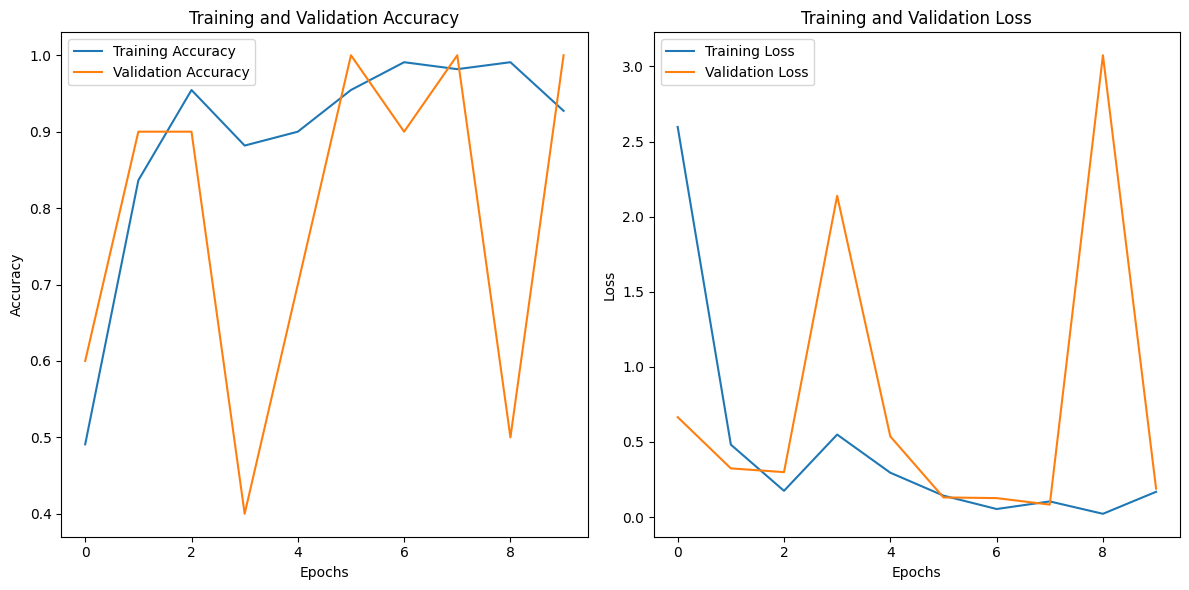

In [ ]:
import os
import imageio
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import Sequence, to_categorical
from sklearn.model_selection import train_test_split

class GifImageGenerator(Sequence):
    def __init__(self, directory, categories, target_size=(224, 224), batch_size=32, class_mode='categorical'):
        print(f"Initializing GifImageGenerator with directory: {directory}")
        self.directory = directory
        self.categories = categories
        self.target_size = target_size
        self.batch_size = batch_size
        self.class_mode = class_mode
        self.image_paths = self.get_image_paths(directory)
        self.indexes = np.arange(len(self.image_paths))

    def get_image_paths(self, directory):
        image_paths = []
        for category in self.categories:
            category_dir = os.path.join(directory, category)
            for subfolder in ['original', 'sketched', 'gifs']:  # Including the gifs folder
                folder_path = os.path.join(category_dir, subfolder)
                if os.path.exists(folder_path):
                    image_paths += [os.path.join(folder_path, fname) for fname in os.listdir(folder_path)]
        return image_paths

    def __len__(self):
        total_images = len(self.image_paths)
        print(f"Total images in this batch: {total_images}")
        return int(np.floor(total_images / self.batch_size))

    def __getitem__(self, index):
        batch_paths = self.image_paths[index * self.batch_size:(index + 1) * self.batch_size]
        images = [self.process_image(path) for path in batch_paths]
        labels = [self.get_label(path) for path in batch_paths]
        return np.array(images), np.array(labels)

    def process_image(self, path):
        # Check if the file is a GIF
        if path.endswith('.gif'):
            img = imageio.mimread(path)[0]  # Load first frame of the GIF
            img = self.resize_image(img)
        else:
            img = image.load_img(path, target_size=self.target_size)
            img = image.img_to_array(img)
        return img / 255.0  # Rescale image

    def resize_image(self, img):
        # Ensure all images are resized to the target size
        resized_img = np.array(image.array_to_img(img).resize(self.target_size))
        return resized_img

    def get_label(self, path):
        # Extract label from the path based on the category
        if 'cat' in path:
            return [1, 0, 0]  # One-hot encoding for 'cat'
        elif 'dog' in path:
            return [0, 1, 0]  # One-hot encoding for 'dog'
        elif 'fox' in path:
            return [0, 0, 1]  # One-hot encoding for 'fox'
        return [0, 0, 0]  # Default if no category match

# Set up directories
train_dir = '/content/Preprocessed_Animal_Images'  # Update this path to your dataset location
categories = ['cat', 'dog', 'fox']

# Instantiate the custom GIF image generator for training
print("Creating training data generator...")
train_generator = GifImageGenerator(train_dir, categories, batch_size=5)  # Adjust batch size

# Split your data into training, validation, and test sets
print("Splitting data into train, validation, and test sets...")
train_paths = train_generator.image_paths
train_paths, val_paths = train_test_split(train_paths, test_size=0.2, random_state=42)  # 80% train, 20% validation
val_paths, test_paths = train_test_split(val_paths, test_size=0.5, random_state=42)  # 50% val, 50% test

# Update the generators with paths
train_generator.image_paths = train_paths
val_generator = GifImageGenerator(train_dir, categories, batch_size=5)
val_generator.image_paths = val_paths

test_generator = GifImageGenerator(train_dir, categories, batch_size=5)
test_generator.image_paths = test_paths

# Define a simple CNN model with Input layer
print("Building CNN model...")
model = Sequential([
    Input(shape=(224, 224, 3)),  # Input layer defining the shape of the images
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(3, activation='softmax')  # 3 output classes (cat, dog, fox)
])

# Compile the model
print("Compiling the model...")
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model using the custom GIF generator with validation
print("Starting model training...")
history = model.fit(
    train_generator,  # Use custom generator for training
    epochs=10,
    validation_data=val_generator  # Provide validation data during training
)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Plot the training and validation accuracy and loss
print("Plotting training and validation results...")
plt.figure(figsize=(12, 6))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')  # Add validation accuracy
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')  # Add validation loss
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

Training and Validation Accuracy:

The training accuracy seems to rise quickly and stabilize at a high value (~1.0), which indicates that the model is fitting very well to the training data.

However, this could also point to overfitting, where the model has learned to memorize the training data.

The validation accuracy starts off lower than training accuracy, which is typical, but it then shows a sharp drop. This suggests that the model is not generalizing well to unseen data. Overfitting is apparent here, as the model performs well on the training data but fails to maintain the same performance on the validation set.

Training and Validation Loss:

Training loss decreases initially and then becomes fairly low, which means the model is minimizing error on the training data over time.

Validation loss, however, spikes in the middle and then continues to decrease, but it still remains higher than the training loss. This is another indicator of overfitting—the model is fitting well to the training data but not generalizing well to the validation data.

Conclusion:

Overfitting is the primary issue here. The model is likely too complex or training for too many epochs without proper regularization, which causes it to perform well on the training data but poorly on the validation set.

To improve the model's generalization:

Reduce the complexity of the model (e.g., fewer layers, fewer neurons per layer).

Use regularization techniques like dropout, L2 regularization, or data augmentation to prevent overfitting.

Early stopping could help by halting the training when the validation loss starts to increase.

Increase training data to help the model learn more diverse features.